## 1. Data Extraction

We first need to extract our data from our CSV files and clean it accordingly into our dataframes. For each of our datasets, we clean the data into 4 columns:
1. Date (in %Y-%m format)
2. Value
3. ChangePercentMonth (percentage change from previous month)
4. ChangePercentYear (percentage change from 12 months ago)

Additionally, we also conduct basic visualisation of our data just to make sure we have cleaned the data correctly. By checking the shape of our data, and plotting a simple time series graph per data set, we were able to spot some issues with our raw data (e.g. S&P500 price in object format instead of float) and clean our data accordingly to make more sense for our project.

In [ ]:
# Importing essential libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import seaborn as sb
import pandas as pd
from datetime import datetime
from functools import reduce
!pip install openpyxl

### Useful Functions
Before we proceed, we have created some useful functions to help us with our data cleaning.

In [47]:
# This function cleans a dataframe to change datetime to %Y-%m format
def df_dates_monthly(df, Date = 'Date'):
    clean_df = df.copy()
    clean_df[Date] = pd.to_datetime(clean_df[Date])
    clean_df[Date] = clean_df[Date].dt.strftime('%Y-%m')
    return clean_df

In [49]:
# This function calculates the ChangePercentMonth and ChangePercentYear
def df_change_percent(df, Value = 'Value'):
    clean_df = df.copy()
    clean_df['ChangePercentMonth'] = round(clean_df[Value].pct_change(),6)
    clean_df['ChangePercentYear'] = round(clean_df[Value].pct_change(12),6)
    return clean_df

### Consumer Price Idex (CPI) Data

First, we import the US CPI data, clean it, calculate the monthly change, and plot it. As mentioned in our README, CPI is the leading measurement of inflation as it calculates the cost of a fixed basket of goods to consumers. All our other data imported below will be compared against our CPI data to study the correlation between those variables vs inflation.

Data source: https://www.bls.gov/cpi/data.htm

In [66]:
cpi_data = pd.read_csv("data/cpi_monthly.csv")
cpi_data = cpi_data.rename(columns={'DATE': 'Date', 'CPIAUCSL': 'Value'})

cpi_data.head()


,Date,Value
0,1947-01-01,21.48
1,1947-02-01,21.62
2,1947-03-01,22.00
3,1947-04-01,22.00
4,1947-05-01,21.95


In [68]:
# Create a copy of the dataset for our lagged CPI predictor
lagged_cpi_data = cpi_data.copy()

lagged_cpi_data['Date'] = pd.to_datetime(lagged_cpi_data['Date'], format='%Y-%m-%d')

# Move all dates by 1 month ahead of time
lagged_cpi_data['Date'] = lagged_cpi_data['Date'] + pd.DateOffset(months=1)
# Clean data to have date in %Y-%m format
lagged_cpi_data_clean = df_dates_monthly(lagged_cpi_data)
# Clean data to have monthly and yearly percentage changes
lagged_cpi_data_clean = df_change_percent(lagged_cpi_data_clean)

In [70]:
# Clean data to have date in %Y-%m format
cpi_data_clean = df_dates_monthly(cpi_data)
# Clean data to have monthly and yearly percentage changes
cpi_data_clean = df_change_percent(cpi_data_clean)
# Show cleaned data
cpi_data_clean

,Date,Value,ChangePercentMonth,ChangePercentYear
0,1947-01,21.480,NaN,NaN
1,1947-02,21.620,0.006518,NaN
2,1947-03,22.000,0.017576,NaN
3,1947-04,22.000,0.000000,NaN
4,1947-05,21.950,-0.002273,NaN
...,...,...,...,...
926,2024-03,312.230,0.003781,0.034751
927,2024-04,313.207,0.003129,0.033577
928,2024-05,313.225,0.000057,0.032502
929,2024-06,313.049,-0.000562,0.029756


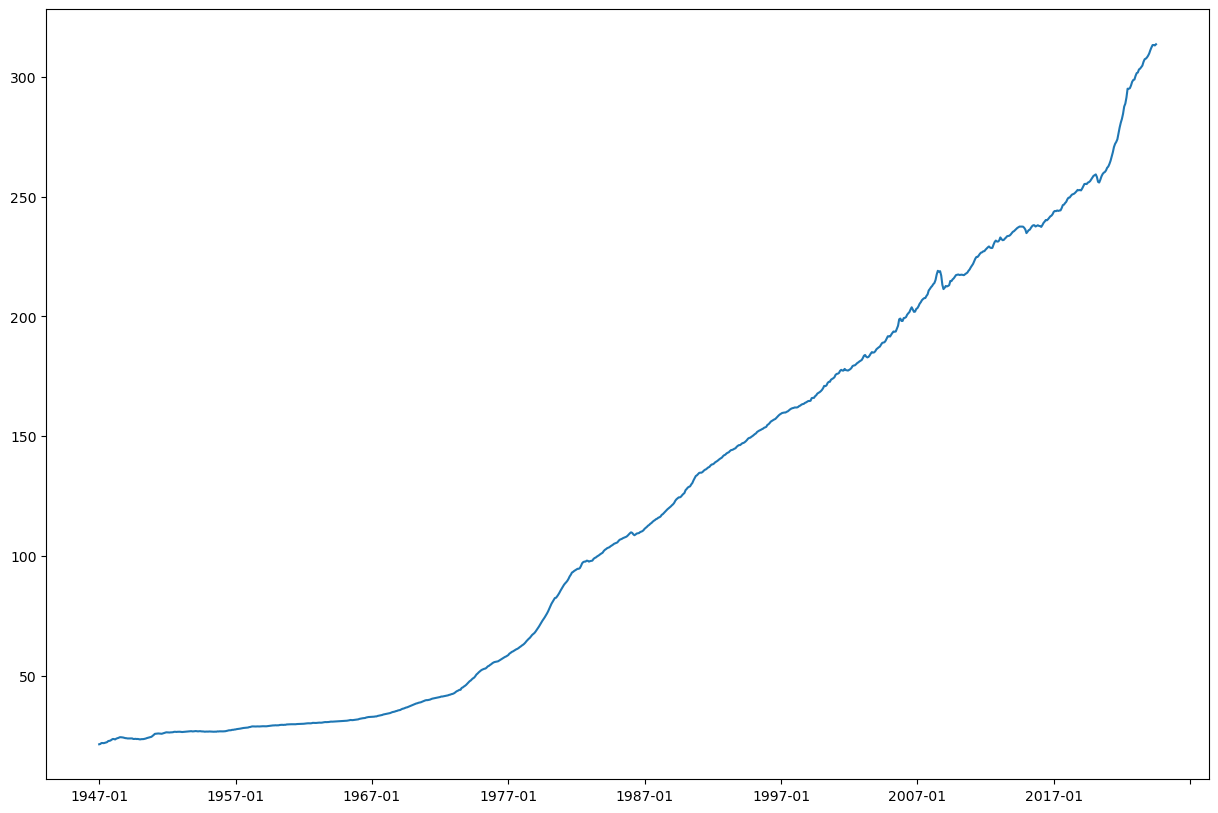

In [72]:
# Plot CPI time series graph
plt.figure(figsize=(15,10))
plt.xticks(np.arange(0, 2000, 120)) # show x-axis ticks at every 10 years
plt.plot(cpi_data_clean['Date'], cpi_data_clean['Value'])
plt.show()

### Business Inflation Expectation (BIE) Data
People’s expectations about future inflation influence their behavior, and thus their expectations are thought to play a role in shaping inflation. As there are several measures of inflation expectations, we choose to use the Business Inflation Expectations (BIE) dataset from the Federal Reserve Bank of Atlanta based on a study conducted by the Federal Reserve Bank of Cleveland which found the survey to have one of the more accurate predictions of CPI inflation one-year out.

The BIE, as measured by the Federal Reserve Bank of Atlanta’s business inflation expectations survey, captures expected growth in the production costs of the firm over the next year.

Data source: https://www.atlantafed.org/research/inflationproject/bie.aspx

Study link: https://www.clevelandfed.org/newsroom-and-events/publications/economic-commentary/2021-economic-commentaries/ec-202119-whose-inflation-expectations-best-predict-inflation.aspx

In [92]:
# Import BIE data and see the head
bie_data = pd.read_excel("data/bie_data.xlsx")
bie_data.columns = ['Date', 'mean','Value']
bie_data = bie_data.drop('mean',axis=1)
bie_data.head()

,Date,Value
0,2011-10-21,0.019269
1,2011-11-18,0.020115
2,2011-12-16,0.018592
3,2012-01-20,0.018283
4,2012-02-17,0.018718


In [94]:
# Look at the shape of our data
bie_data.shape

(156, 2)

In [96]:
# Since this data looks ahead 1 year at inflation, we need to bring the dates forward by 1 year as well
bie_data['Date'] = bie_data['Date'] + pd.DateOffset(months=12)

In [98]:
# Clean BIE data by rounding Value
bie_data['Value'] = round(bie_data['Value'],6)
# Clean data to have date in %Y-%m format
bie_clean = df_dates_monthly(bie_data)
# Clean data to have monthly and yearly percentage changes
bie_clean = df_change_percent(bie_clean)
# Show cleaned data
bie_clean

# Calculate month on month and year on year percentage changes
bie_clean['ChangePercentMonth'] = round(bie_clean['Value'].pct_change(),6)
bie_clean['ChangePercentYear'] = round(bie_clean['Value'].pct_change(12),6)
bie_clean

,Date,Value,ChangePercentMonth,ChangePercentYear
0,2012-10,0.019269,NaN,NaN
1,2012-11,0.020115,0.043905,NaN
2,2012-12,0.018592,-0.075715,NaN
3,2013-01,0.018283,-0.016620,NaN
4,2013-02,0.018718,0.023793,NaN
...,...,...,...,...
151,2025-05,0.023126,0.013232,-0.213053
152,2025-06,0.022759,-0.015870,-0.147092
153,2025-07,0.023897,0.050002,-0.160920
154,2025-08,0.021517,-0.099594,-0.147098


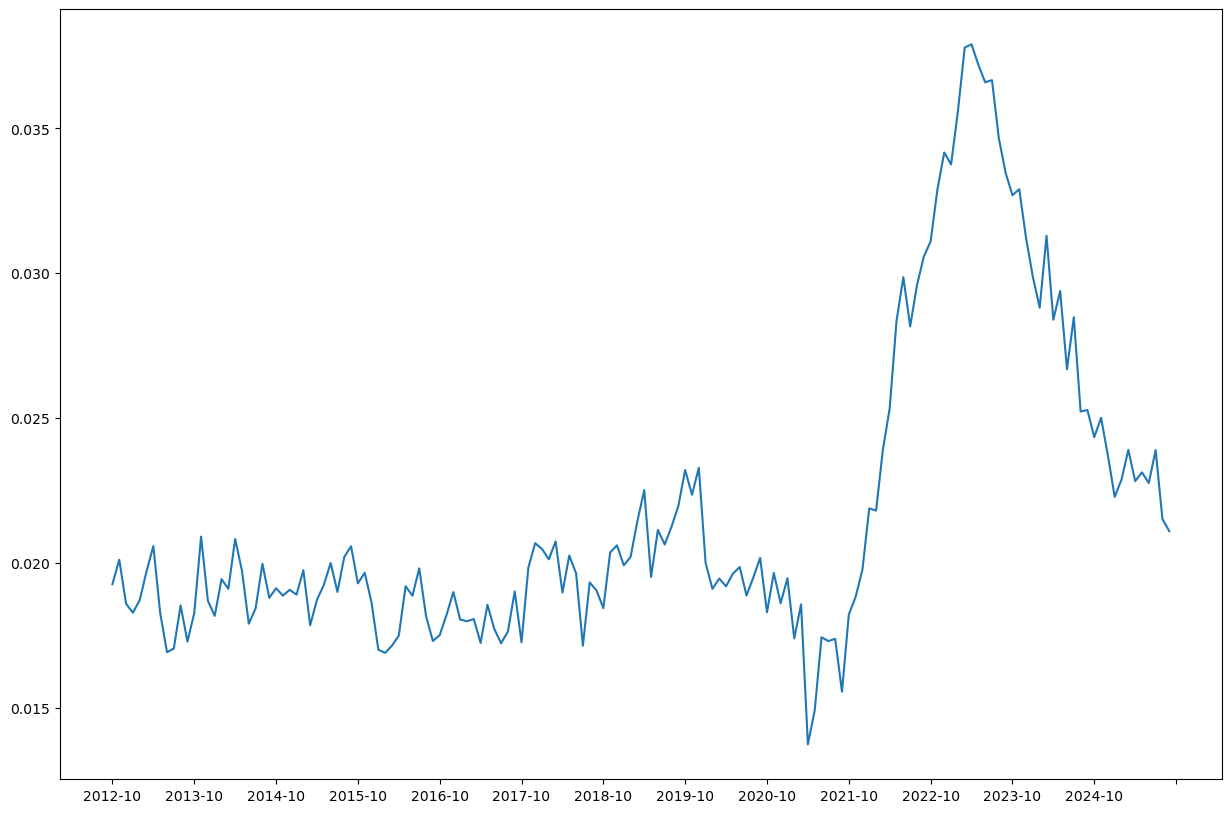

In [100]:
# Plot BIE time series graph
plt.figure(figsize=(15,10))
plt.xticks(np.arange(0, 2000, 12)) # show x-axis ticks at every 1 year
plt.plot(bie_clean['Date'], bie_clean['Value'])

### Oil Price Data
The West Texas Intermediate (WTI) benchmark for US crude is the world's most actively traded commodity. Crude Oil prices displayed in Trading Economics are based on over-the-counter (OTC) and contract for difference (CFD) financial instruments

Data source: https://tradingeconomics.com/commodity/crude-oil

In [76]:
# Import oil price data and see the head
oil_pd = pd.read_csv("data/crudeoil_monthly.csv")
oil_pd

,Date,Value
0,Jan-1986,22.93
1,Feb-1986,15.46
2,Mar-1986,12.61
3,Apr-1986,12.84
4,May-1986,15.38
...,...,...
459,Apr-2024,85.35
460,May-2024,80.02
461,Jun-2024,79.77
462,Jul-2024,81.80


In [80]:
# Clean data to have date in %Y-%m format
oil_clean = pd.DataFrame(df_dates_monthly(oil_pd,'Date')[['Date', 'Value']])
oil_clean.columns = ['Date', 'Value']
# Clean data to have monthly and yearly percentage changes
oil_clean = df_change_percent(oil_clean)
# Show cleaned data
oil_clean

/var/folders/mq/2hlc7t3j1n70sc6bwnvg849r0000gn/T/ipykernel_56209/4267578931.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  clean_df[Date] = pd.to_datetime(clean_df[Date])


,Date,Value,ChangePercentMonth,ChangePercentYear
0,1986-01,22.93,NaN,NaN
1,1986-02,15.46,-0.325774,NaN
2,1986-03,12.61,-0.184347,NaN
3,1986-04,12.84,0.018239,NaN
4,1986-05,15.38,0.197819,NaN
...,...,...,...,...
459,2024-04,85.35,0.050074,0.074261
460,2024-05,80.02,-0.062449,0.117910
461,2024-06,79.77,-0.003124,0.135516
462,2024-07,81.80,0.025448,0.075325


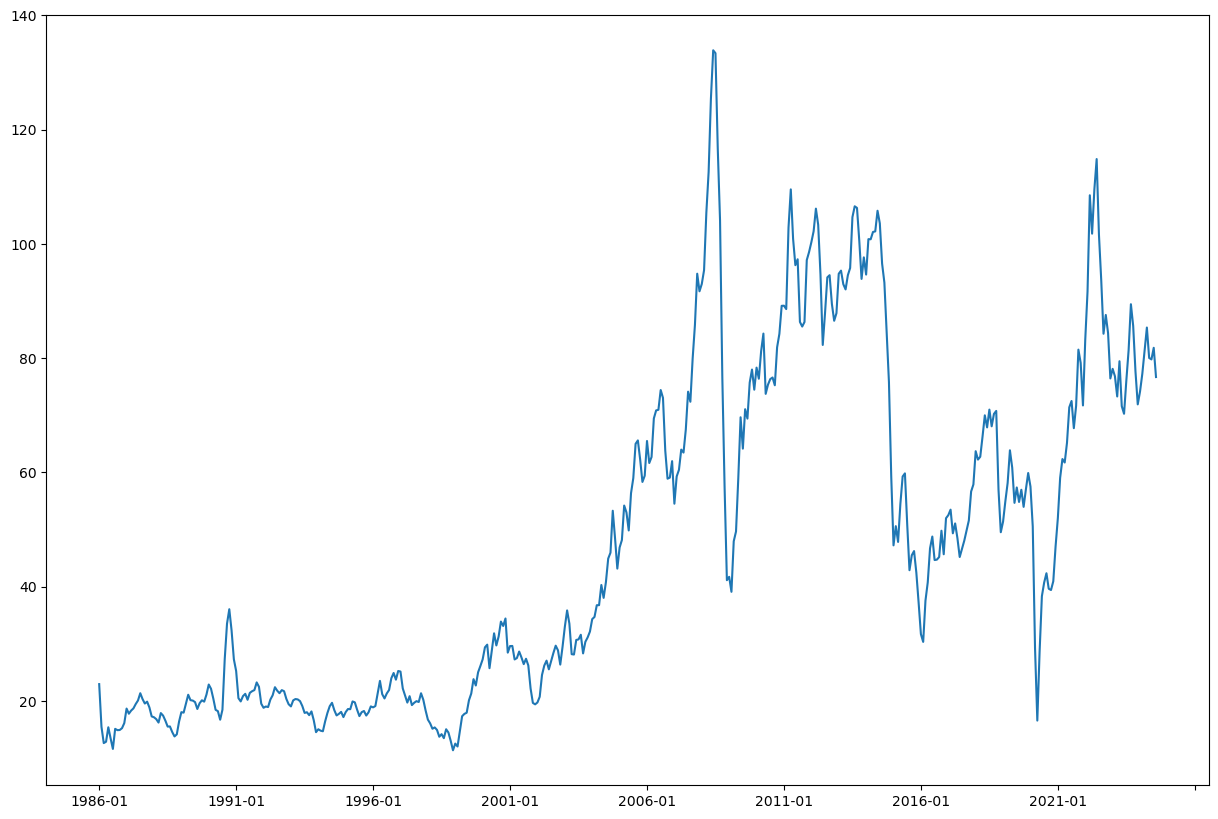

In [82]:
# Plot oil price time series graph
plt.figure(figsize=(15,10))
plt.xticks(np.arange(0, 2000, 60)) # show x-axis ticks at every 5 years
plt.plot(oil_clean['Date'], oil_clean['Value'])

### Producer Price Index (PPI) Data

The US Producer Price Index measures average changes in prices received by domestic producers for their output. This metric can be used as a gauge for how much pricing power producers have. It is used in conjunction with the Consumer Price Index (CPI) to understand how prices are changing in the US economy. A change in the PPI often anticipates a change in the CPI.

We use Producer Price Index by Commodity: All Commodities

Data source: https://fred.stlouisfed.org/series/PPIACO

In [103]:
ppi_data = pd.read_csv("data/ppi_monthly.csv")
ppi_data.columns = ['Date', 'Value']
ppi_data.head()

,Date,Value
0,1913-01-01,12.1
1,1913-02-01,12.0
2,1913-03-01,12.0
3,1913-04-01,12.0
4,1913-05-01,11.9


In [105]:
# Look at the shape of our data
ppi_data.shape

(1339, 2)

In [107]:
# Clean data to have date in %Y-%m format
ppi_data_clean = df_dates_monthly(ppi_data)
# Clean data to have monthly and yearly percentage changes
ppi_data_clean = df_change_percent(ppi_data_clean)
# Show cleaned data
ppi_data_clean

,Date,Value,ChangePercentMonth,ChangePercentYear
0,1913-01,12.100,NaN,NaN
1,1913-02,12.000,-0.008264,NaN
2,1913-03,12.000,0.000000,NaN
3,1913-04,12.000,0.000000,NaN
4,1913-05,11.900,-0.008333,NaN
...,...,...,...,...
1334,2024-03,255.095,0.000663,-0.007652
1335,2024-04,256.984,0.007405,0.000296
1336,2024-05,255.268,-0.006677,0.006300
1337,2024-06,255.779,0.002002,0.007559


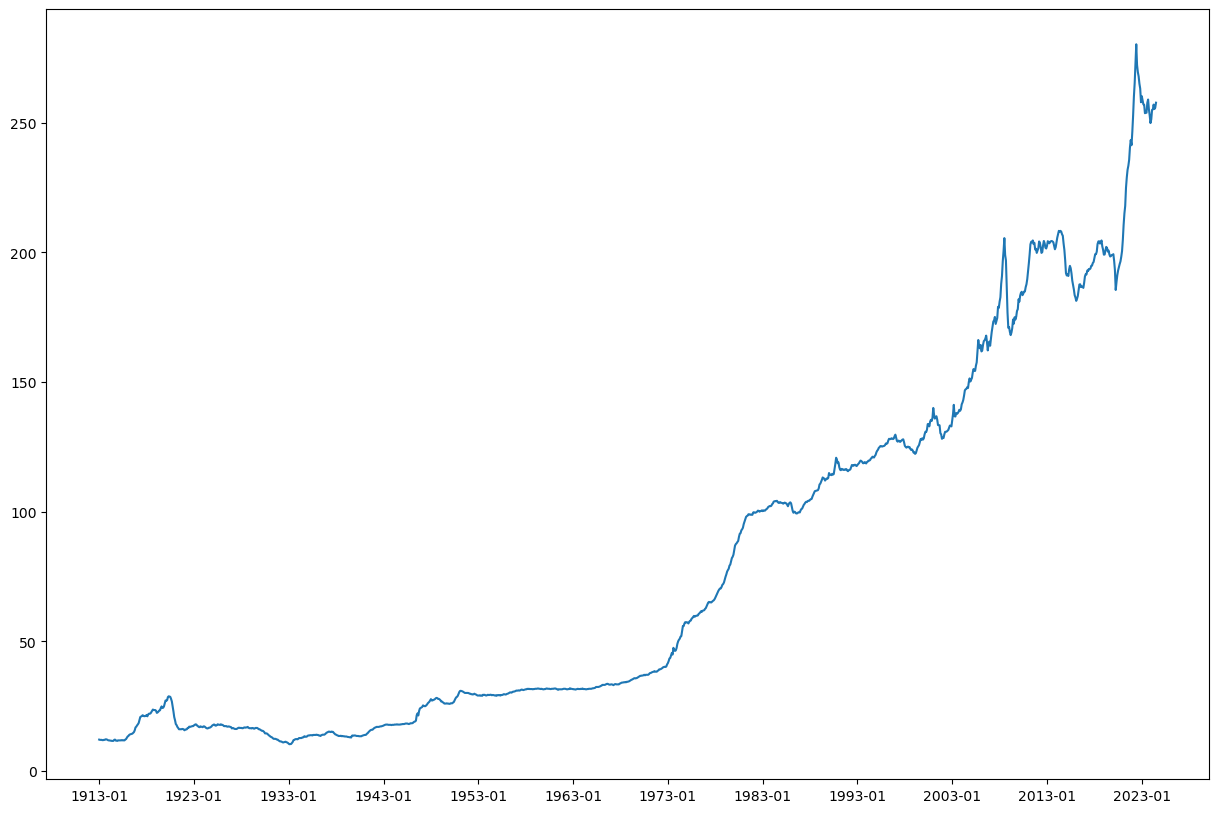

In [109]:
# Plot PPI time series graph
plt.figure(figsize=(15,10))
plt.xticks(np.arange(0, 2000, 120)) # show x-axis ticks at every 10 years
plt.plot(ppi_data_clean['Date'], ppi_data_clean['Value'])
plt.show()

### S&P 500 Monthly Data

The S&P500 is an index which tracks the prices of the top 500 stocks in the USA. It will be interesting to compare this against the CPI to study how stock performance correlates to inflation. This could perhaps help us draw conclusions as to how company performance is affected by inflation, or to how stock market investors allocate their funds differently (e.g. put into stocks or reallocate to safer assets) during times of high inflation, healthy inflation, or deflation.

In [112]:
sp_data = pd.read_csv("data/sp_monthly.csv")
sp_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1985-01-01,167.199997,180.270004,163.360001,179.630005,179.630005,2.673710e+09
1,1985-02-01,179.630005,183.949997,177.750000,181.179993,181.179993,2.194620e+09
2,1985-03-01,181.179993,183.889999,176.529999,180.660004,180.660004,2.153090e+09
3,1985-04-01,180.660004,183.610001,177.860001,179.830002,179.830002,1.981880e+09
4,1985-05-01,179.830002,189.979996,178.350006,189.550003,189.550003,2.350340e+09


In [114]:
# Look at the shape of our data
sp_data.shape

(478, 7)

In [126]:
# Clean data to have date in %Y-%m format
# sp_data['Date'] = pd.to_datetime(sp_data['Date'], format='%b %y')
sp_data = df_dates_monthly(sp_data)
# Clean S&P data to keep only Date and Value columns, sorted in ascending order of date
sp_data_clean = pd.DataFrame(sp_data[['Date','Open']])
sp_data_clean.columns = ['Date', 'Value']
# sp_data_clean['Value'] = sp_data_clean['Value'].str.replace(',', '').astype(float)
sp_data_clean.sort_values(by=['Date'], inplace=True)
# Clean data to have monthly and yearly percentage changes
sp_data_clean = df_change_percent(sp_data_clean)
# Show cleaned data
sp_data_clean

/var/folders/mq/2hlc7t3j1n70sc6bwnvg849r0000gn/T/ipykernel_56209/579789466.py:4: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  clean_df['ChangePercentMonth'] = round(clean_df[Value].pct_change(),6)
/var/folders/mq/2hlc7t3j1n70sc6bwnvg849r0000gn/T/ipykernel_56209/579789466.py:5: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  clean_df['ChangePercentYear'] = round(clean_df[Value].pct_change(12),6)


,Date,Value,ChangePercentMonth,ChangePercentYear
0,1985-01,167.199997,NaN,NaN
1,1985-02,179.630005,0.074342,NaN
2,1985-03,181.179993,0.008629,NaN
3,1985-04,180.660004,-0.002870,NaN
4,1985-05,179.830002,-0.004594,NaN
...,...,...,...,...
473,2024-06,5297.149902,0.053314,0.266343
474,2024-07,5471.080078,0.032835,0.229324
475,2024-08,5537.839844,0.012202,0.209444
476,2024-09,NaN,0.000000,0.222319


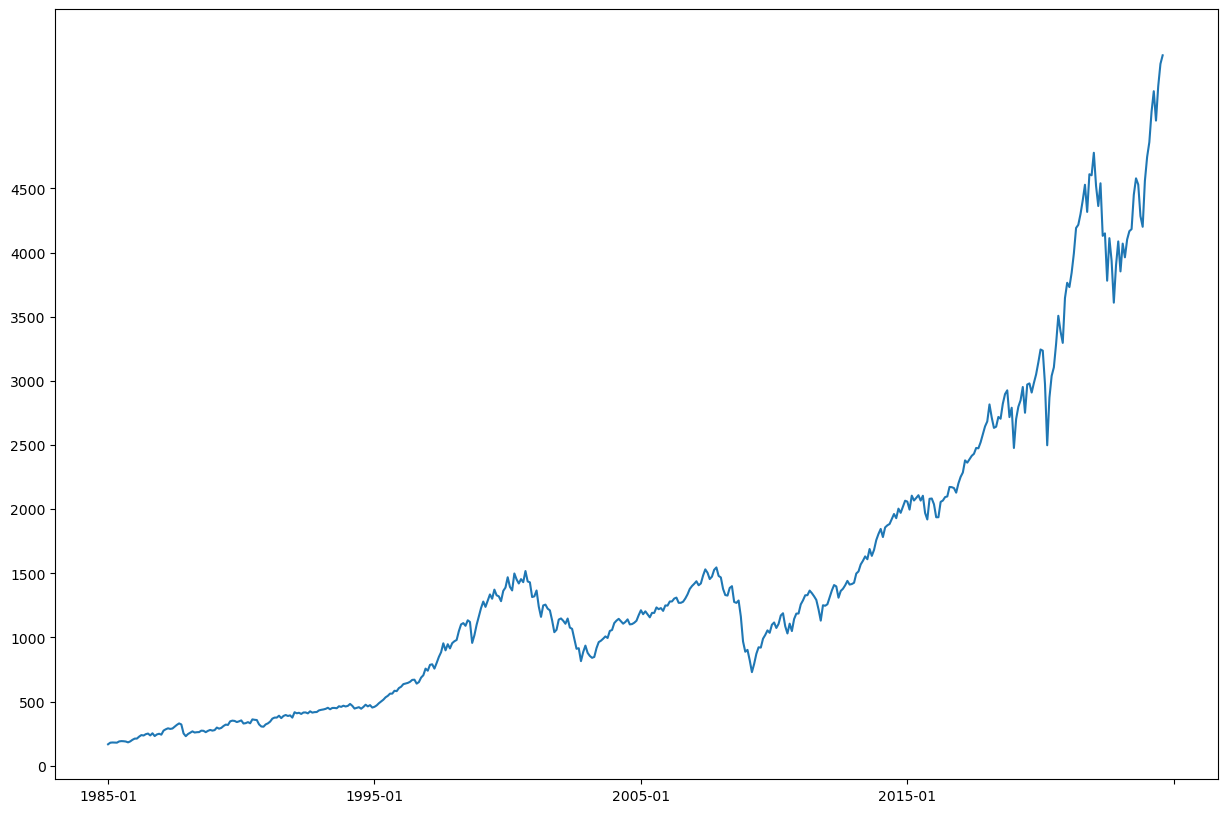

In [128]:
# Plot S&P500 time series graph
plt.figure(figsize=(15,10))
plt.xticks(np.arange(0, 2000, 120)) # show x-axis ticks at every 10 years
plt.yticks(np.arange(0, 5000, 500)) # show y-axis ticks at every $500
plt.plot(sp_data_clean['Date'], sp_data_clean['Value'])
plt.show()

### Nominal Effective Exchange Rate
The nominal effective exchange rate (NEER) is an unadjusted weighted average rate at which one country's currency exchanges for a basket of multiple foreign currencies. The nominal exchange rate is the amount of domestic currency needed to purchase foreign currency.

In economics, the NEER is an indicator of a country's international competitiveness in terms of the foreign exchange (forex) market. Forex traders sometimes refer to the NEER as the trade-weighted currency index.

If a domestic currency increases against a basket of other currencies inside a floating exchange rate regime, NEER is said to appreciate. If the domestic currency falls against the basket, the NEER depreciates.

The NEER only describes relative value; it cannot definitively show whether a currency is strong or gaining strength in real terms. It only describes whether a currency is weak or strong, or weakening or strengthening, compared to foreign currencies. As with all exchange rates, the NEER can help identify which currencies store value more or less effectively. Exchange rates influence where international actors buy or sell goods.

NEER is used in economic studies and for policy analysis on international trade. It is also used by forex traders who engage in currency arbitrage. The Federal Reserve calculates three different NEER indices for the United States: the broad index, the Advanced Foreign Economies (AFE) and the Emerging Market Economies (EME)

We use the NEER for the US

Data Source: https://fred.stlouisfed.org/series/NBUSBIS 

In [135]:
# Import NEER data and see the head
neer_pd = pd.read_csv('data/NBUSBIS.csv')
neer_pd.columns = ['Date', 'Value']
neer_pd

,Date,Value
0,1994-01-01,71.18
1,1994-02-01,71.26
2,1994-03-01,71.76
3,1994-04-01,72.39
4,1994-05-01,72.36
...,...,...
362,2024-03-01,104.26
363,2024-04-01,105.39
364,2024-05-01,105.21
365,2024-06-01,106.76


In [137]:
# Look at the shape of our data
neer_pd.shape

(367, 2)

In [139]:
# Clean data to have date in %Y-%m format
neer_data_clean = df_dates_monthly(neer_pd)
# Clean data to have monthly and yearly percentage changes
neer_data_clean = df_change_percent(neer_data_clean)
# Show cleaned data
neer_data_clean

,Date,Value,ChangePercentMonth,ChangePercentYear
0,1994-01,71.18,NaN,NaN
1,1994-02,71.26,0.001124,NaN
2,1994-03,71.76,0.007017,NaN
3,1994-04,72.39,0.008779,NaN
4,1994-05,72.36,-0.000414,NaN
...,...,...,...,...
362,2024-03,104.26,-0.002392,0.009684
363,2024-04,105.39,0.010838,0.031516
364,2024-05,105.21,-0.001708,0.024440
365,2024-06,106.76,0.014732,0.036002


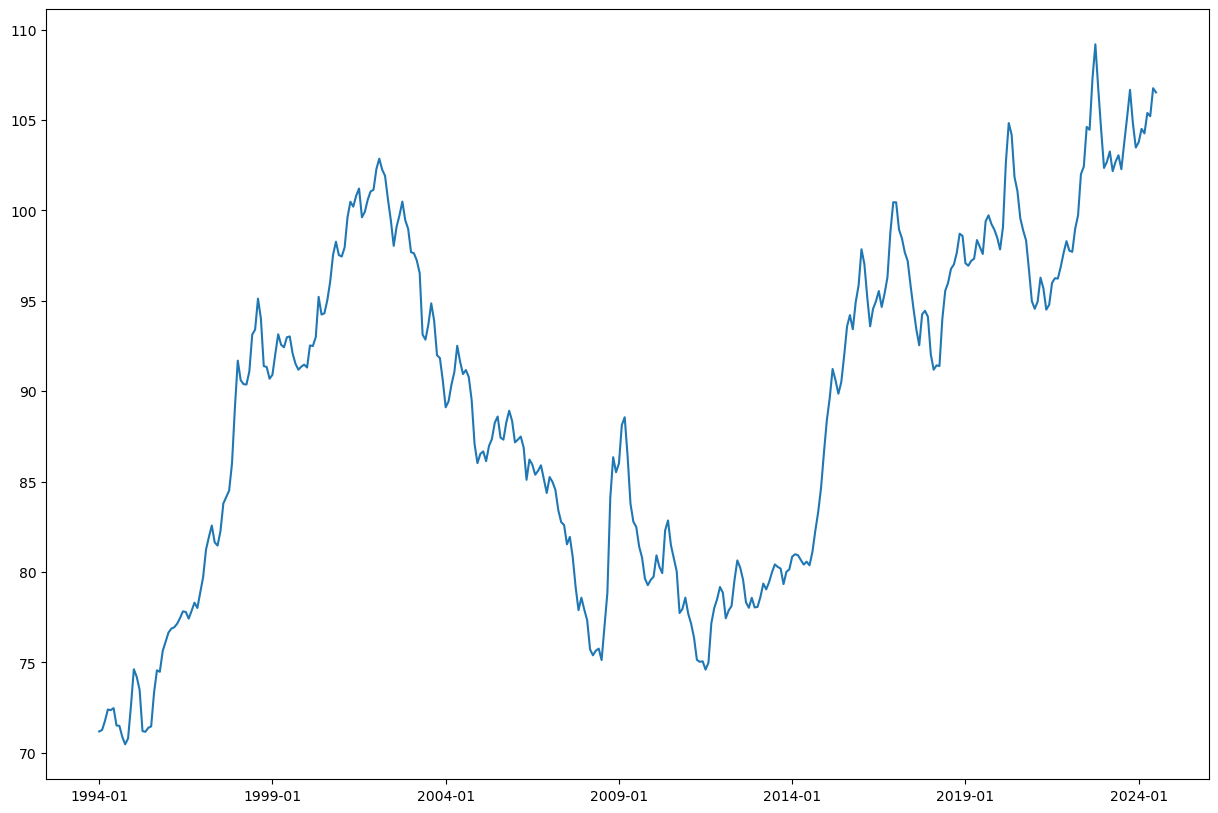

In [141]:
# Plot NEER time series graph
plt.figure(figsize=(15,10))
plt.xticks(np.arange(0, 2000, 60)) # show x-axis ticks at every 5 years
plt.plot(neer_data_clean['Date'], neer_data_clean['Value'])
plt.show()

### US Unemployment Rate Data

Unemployment rate is a key factor in indicating a country's economic growth and demand for its goods and services. Low unemployment is usually an indicator of a country's strong growth and economic productivity. This makes it a likely demand push factor in influencing the rate of inflation in a country.

Data source: https://www.kaggle.com/datasets/axeltorbenson/unemployment-data-19482021

In [144]:
# Import enemployment data and see the head
unemp_data = pd.read_csv("data/unemployment_rate_data.csv")
unemp_data.head()

,date,unrate,unrate_men,unrate_women,unrate_16_to_17,unrate_18_to_19,unrate_20_to_24,unrate_25_to_34,unrate_35_to_44,unrate_45_to_54,unrate_55_over
0,1/1/1948,4.0,4.2,3.5,10.8,9.6,6.6,3.6,2.6,2.7,3.6
1,2/1/1948,4.7,4.7,4.8,15.0,9.5,8.0,4.0,3.2,3.4,4.0
2,3/1/1948,4.5,4.5,4.4,13.2,9.3,8.6,3.5,3.2,2.9,3.5
3,4/1/1948,4.0,4.0,4.1,9.9,8.1,6.8,3.5,3.1,2.9,3.2
4,5/1/1948,3.4,3.3,3.4,6.4,7.2,6.3,2.8,2.5,2.3,2.9


In [146]:
# Look at the shape of our data
unemp_data.shape

(887, 11)

In [148]:
# Clean unemployment data to keep columns Date and unemployment rate
unemp_data_clean = pd.DataFrame(unemp_data[['date','unrate']])
unemp_data_clean.columns = ['Date', 'Value']

# Clean data to have date in %Y-%m format
unemp_data_clean = df_dates_monthly(unemp_data_clean)
# Clean data to have monthly and yearly percentage changes
unemp_data_clean = df_change_percent(unemp_data_clean)
# Show cleaned data
unemp_data_clean

,Date,Value,ChangePercentMonth,ChangePercentYear
0,1948-01,4.0,NaN,NaN
1,1948-02,4.7,0.175000,NaN
2,1948-03,4.5,-0.042553,NaN
3,1948-04,4.0,-0.111111,NaN
4,1948-05,3.4,-0.150000,NaN
...,...,...,...,...
882,2021-07,5.7,-0.065574,-0.457143
883,2021-08,5.3,-0.070175,-0.376471
884,2021-09,4.6,-0.132075,-0.402597
885,2021-10,4.3,-0.065217,-0.348485


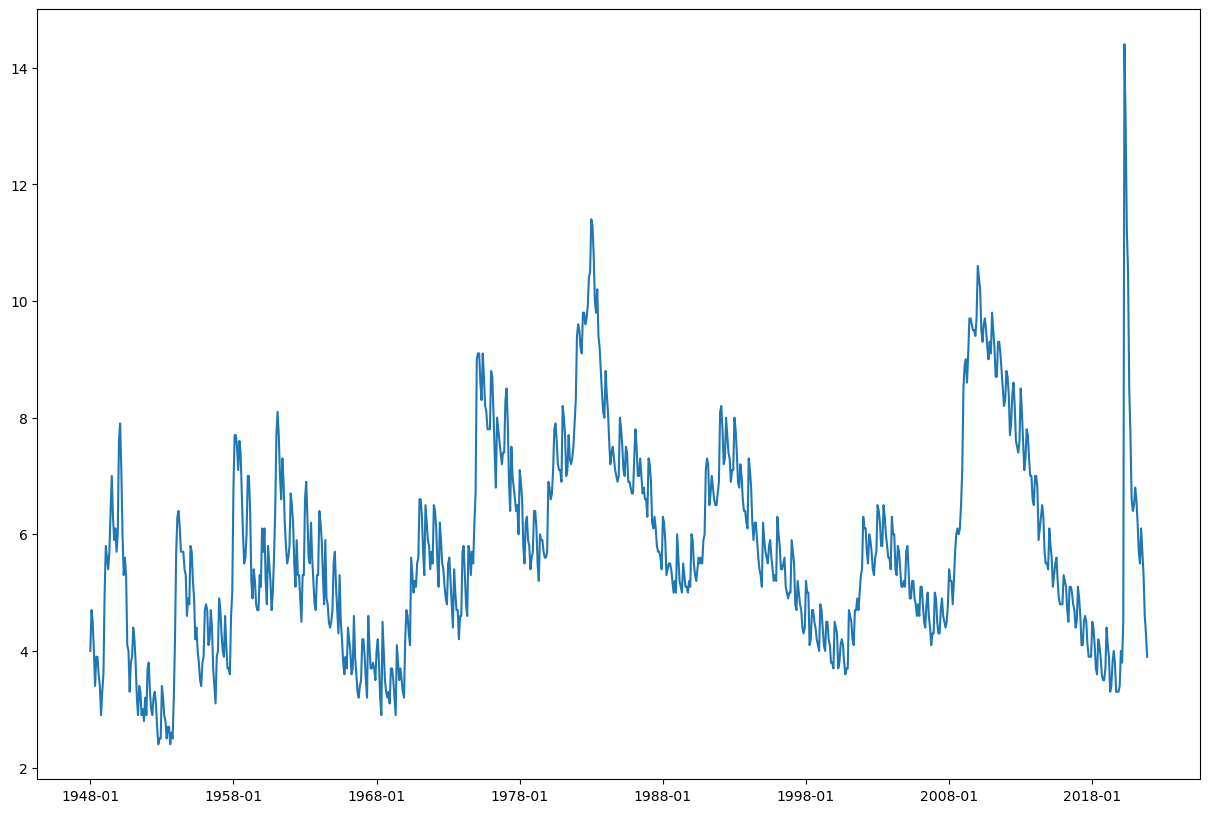

In [150]:
# Plot unemloyment rate time series graph
plt.figure(figsize=(15,10))
plt.xticks(np.arange(0, 2000, 120)) # show x-axis ticks at every 10 years
plt.plot(unemp_data_clean['Date'], unemp_data_clean['Value'])
plt.show()

In [154]:
# Export to CSV
cpi_data_clean.to_csv('data/cleaned/cleaned_cpi.csv', index=False)
bie_clean.to_csv('data/cleaned/cleaned_bie.csv', index=False)
oil_clean.to_csv('data/cleaned/cleaned_oil.csv', index=False)
ppi_data_clean.to_csv('data/cleaned/cleaned_ppi.csv', index=False)
unemp_data_clean.to_csv('data/cleaned/cleaned_unemp.csv', index=False)
neer_data_clean.to_csv('data/cleaned/cleaned_neer.csv', index=False)
lagged_cpi_data_clean.to_csv('data/cleaned/cleaned_lagged_cpi.csv', index=False)
sp_data_clean.to_csv('data/cleaned/cleaned_sp.csv', index=False)